### Mass segregation

Analysis of the mass segregation in the stellar clusters using different indices <br>
In particular we use the MST-based metric (e.g. Yu et al. 2011)

In [1]:
using PyCall
using Distributions
using Statistics
using DataFrames
using Distances, LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

rootdir = "/home/stephane/Science/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

import PyPlot , CSV

@pyimport astroquery.vizier as vizier
@pyimport astropy.units as u
@pyimport astropy.coordinates as coord


## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc"

cd(wdir)

┌ Info: Recompiling stale cache file /home/stephane/.julia/compiled/v1.1/GaiaClustering.ji for GaiaClustering [top-level]
└ @ Base loading.jl:1184
┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:407
└ @ PyCall /home/stephane/.julia/packages/PyCall/ttONZ/src/PyCall.jl:407


In [2]:
## Test OC
##

#oc= CSV.read("$ocdir/NGC 6124-2.3deg-oc.csv" , delim= ";")
oc= CSV.read("$ocdir/NGC 7086-1.0deg-oc.csv", delim= ";")

,ra,dec,l,b,distance,pmra,pmdec,X,Y,Z,vl,vb,vrad,gbar,rp,bp
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,322.588,51.3556,94.2283,0.0521341,1672.01,-1.69564,-1.56564,1671.99,-5.89749,-3.76196,-18.2902,0.152185,NaN,15.0727,13.5945,14.6117
2,322.686,51.3391,94.2614,-0.00153599,1640.93,-1.66993,-1.61461,1640.91,-4.84059,-5.22912,-18.0648,-0.289149,NaN,16.3507,14.6722,16.0221
3,322.601,51.3638,94.2395,0.0527067,1642.32,-1.54933,-1.66081,1642.31,-5.47028,-3.67876,-17.6421,-1.17318,NaN,16.1403,14.509,15.7678
4,322.805,51.4962,94.4229,0.0624116,1693.41,-1.66808,-1.64562,1693.41,-0.220098,-3.50636,-18.8011,-0.520765,NaN,14.675,13.2838,14.1834
5,322.621,51.5978,94.4089,0.214773,1605.36,-1.87723,-1.61163,1605.36,-0.6029,0.944947,-18.8085,0.828554,NaN,15.3795,13.3523,14.3225
6,322.455,51.3924,94.1931,0.135711,1705.14,-1.61338,-1.49453,1705.13,-7.06308,-1.34923,-17.7743,0.15136,NaN,14.5613,13.2231,14.0487
7,322.598,51.6286,94.4197,0.246928,1749.06,-1.88835,-1.69633,1749.06,-0.327476,2.01112,-21.0396,0.460219,NaN,17.1825,15.5454,17.1161
8,322.668,51.5685,94.4105,0.173195,1720.84,-1.56654,-1.92731,1720.84,-0.598675,-0.235865,-20.073,-2.73675,NaN,18.5067,16.7454,18.5308
9,322.574,51.6506,94.4239,0.273015,1691.94,-1.6225,-1.7202,1691.94,-0.190436,2.71579,-18.9293,-1.14738,NaN,13.0162,11.622,12.5172


In [3]:
## Create a graph with the selected stars
## ind: subset to select the x,y
## dtyp= "2d" or "3d"

function _mst_graph(ind,x,y,z=[] , dtyp="2d")
    nxy= length(ind)
    if dtyp == "2d"
        A= Array{Float64}(undef,2,nxy)
    elseif dtyp == "3d"
       A= Array{Float64}(undef,3,nxy) 
    end
    
    for i in 1:nxy
        if dtyp == "2d"
            A[:,i]= [x[ind[i]] y[ind[i]]]
        elseif dtyp == "3d"
            A[:,i]= [x[ind[i]] y[ind[i]] z[ind[i]]]
        end
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    #println(p)
    
    src= Array{Int}(undef,0)
    dst= Array{Int}(undef,0)
    wgt= Array{Float64}(undef,0)

    for i in 1:nxy
        for j in 1:nxy
            if i != j
                push!(src,i)
                push!(dst,j)
                push!(wgt,p[i,j]) 
            end
        end
    end
    
    G= SimpleWeightedGraph(src, dst, wgt)
    
    kr= kruskal_mst(G, G.weights)
    
    #for w in kr
    #    @printf("%d - %d : %3.3f\n",w.src,w.dst, w.weight)
    #end
    
    return(kr)
end


_mst_graph (generic function with 3 methods)

In [4]:
## Computation of the λMST using either arithmetic or geometric average (Olczak et al. 2011)
##
## dtype= "ari" or "geo"
function _lambda_mst(edges, dtyp="ari")
    nedg= length(edges)
    # println(nedg)
    ltot= 0
    
    for w in edges
        if dtyp== "ari"
            ltot+= w.weight
        elseif dtyp== "geo"
            ltot+= log(w.weight)
        end
    end
    
    if dtyp== "ari"
        λmst= ltot/nedg
    elseif dtyp== "geo"
        λmst= exp(ltot/nedg)
    end
    return(λmst)
end

## estimate the sample size for the stats given n and N for the massive and total sample
## p= 99%
## Olczak et al. 2011)
function _sample_size(n, N, p=0.99)
    k= log(1-p)/log(1-n/N)
    return(convert(Int,ceil(k)))
end

## Compute the mass segregation metric comparing two population set (2nd is random)
##
## nrandom: number of random set (default=1)
##
function _kappa_ms(indMass, x, y , z, nrandom=1, dtyp="2d", daver= "geo")
    npop= length(indMass)
    ntot= length(x)
    
    ## Massive stars
    krMass= _mst_graph(indMass, x,y,z , dtyp)
    λMass= _lambda_mst(krMass,daver)
    ## Random set
    λArr= []
    κArr= []
    for i in 1:nrandom
        perm= randperm(ntot)
        indRef= perm[1:npop]
        krRef= _mst_graph(indRef, x,y,z, dtyp)
        λRef= _lambda_mst(krRef,daver)
        push!(λArr,λRef)
        push!(κArr, log(λRef/λMass))
    end
    λMean= mean(λArr)
    σκ= std(κArr)
    ## ratio (log) of the reference over massive ones
    κms= log(λMean/λMass)
    
    return(κms , σκ)
end

_kappa_ms (generic function with 4 methods)

In [5]:
## Select the N percentile most massive stars (brighter)
##

function _select_massivestars(mag, percentile=5 , reverse=false)
    nstar= length(mag)
    isort= sortperm(mag, rev=reverse)
    
    nselect= convert(Int, floor(nstar*percentile/100))
    return(isort[1:nselect])
end


## return the MS kappa and kappa_err
## IN
## mag: magnitude array
## X,Y,Z: positions array
## perc: percentile of massive stars
## dtyp: "3d" or "2d"
## daver: "geo" or "ari"
## reverse: false:massive, true:light - stars

function _get_kappaMS(mag, X, Y, Z, perc, dtyp="3d", daver="geo", reverse=false)
    imass= _select_massivestars(mag, perc, reverse)
    ns= _sample_size(length(imass), length(X))
    κms, κms_err= _kappa_ms(imass, X, Y, Z, ns, dtyp, daver)
    return(κms, κms_err)
end

_get_kappaMS (generic function with 4 methods)

In [6]:
## Compute the Q ratio structure to measure the clustering of the OC.
## See Cartwright et al. (2004)
## directly adapted to 3D
##

### !!!!!!! Normalization to be checked on λ , Cartwright & 2004
function _get_Q(X, Y , Z)
    nxyz= length(X)
    A= Array{Float64}(undef,3,nxyz) 
    for i in 1:nxyz
            A[:,i]= [X[i] Y[i] Z[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    
    src= Array{Int}(undef,0)
    dst= Array{Int}(undef,0)
    wgt= Array{Float64}(undef,0)

    for i in 1:nxyz
        for j in 1:nxyz
            if i != j
                push!(src,i)
                push!(dst,j)
                push!(wgt,p[i,j]) 
            end
        end
    end
    
    G= SimpleWeightedGraph(src, dst, wgt)
    kr= kruskal_mst(G, G.weights)
    
    ## compute the mean (arithmtic) edge of MST and of star separation. We do not apply other normalization
    λmst= 0
    for w in kr
        λmst+= w.weight
    end
    ## not the original normalization of Cartwright!
    k= (4π / 3 / nxyz )^(1/3)
    λmst /= k*length(kr)
    
    npair= nxyz*(nxyz-1)/2
    sbar= sum(p) / npair
    
    Q= λmst / sbar
end

_get_Q (generic function with 1 method)

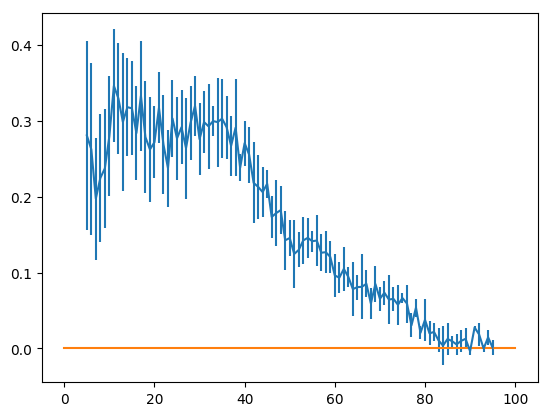

0.30929209039839295
0.07707671292305804


In [7]:
## Main

# kr= _mst_graph([1,5,10,16,20,27,30], oc[:X], oc[:Y] , oc[:Z] , "2d")
#  _lambda_mst(kr,"geo")


imass= _select_massivestars(oc[:gbar], 15)
ns= _sample_size(length(imass), length(oc[:X]))
y, yerr= _kappa_ms( imass, oc[:X], oc[:Y] , oc[:Z], ns, "3d", "geo")
println(y)
println(yerr)


## plots..

percentile=[]
Κms= []
errΚms= []

for perc in 5:95
    push!(percentile, perc)
     imass= _select_massivestars(oc[:gbar], perc, false)
    ns= _sample_size(length(imass), length(oc[:X]))
    y, yerr= _kappa_ms( imass, oc[:X], oc[:Y] , oc[:Z], ns, "3d", "geo")
    push!(Κms, y)
    push!(errΚms, yerr)   
end


PyPlot.errorbar(percentile, Κms, yerr=errΚms)
PyPlot.plot([0,100],[0,0])
PyPlot.show()

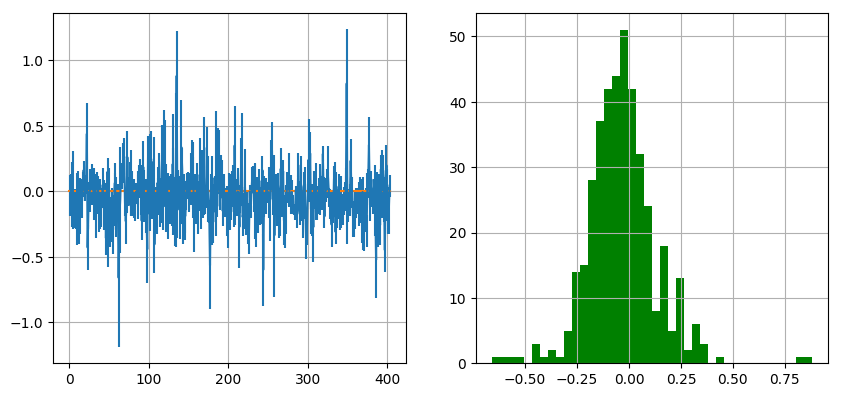

-0.03375937140562855


In [8]:
## Loop over all OCs

cd(ocdir)
files= glob("*csv")
cd(wdir)

percms= 10
ilabel= []
Κms= []
errΚms= []
i= 0
for f in files
    i+= 1
    oc= CSV.read("$ocdir/$f" , delim= ";")
    # imass= _select_massivestars(oc[:gbar], percms)
    # ns= _sample_size(length(imass), length(oc[:X]))
    # y, yerr= _kappa_ms( imass, oc[:X], oc[:Y] , oc[:Z], ns, "3d", "geo")
    y, yerr= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], percms, "3d", "geo", true)
    #y= _get_Q(oc[:X], oc[:Y] , oc[:Z]) ; yerr=1
    push!(ilabel, i)
    push!(Κms, y)
    push!(errΚms, yerr)  
end

println(mean(Κms))

fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.errorbar(ilabel, Κms, yerr=errΚms)
PyPlot.plot([0,length(ilabel)],[0,0])

ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.hist(Κms , 40, density=false, facecolor="g")

PyPlot.show()

In [9]:
### Q structure factor
_get_Q(oc[:X], oc[:Y] , oc[:Z])

0.30986790985762763

In [10]:
## looping on all OCs to compute MS and Q
##
ocage= CSV.read("votlist.finalSample_metric0.01-age.csv", delim=";")

t1= Array{Float64,1}(undef,0) ; t2= Array{Float64,1}(undef,0) ; t3= Array{Float64,1}(undef,0)
t4= Array{Float64,1}(undef,0) ; t5= Array{Float64,1}(undef,0) ; t6= Array{Float64,1}(undef,0)

t7= Array{Float64,1}(undef,0) ; t8= Array{Float64,1}(undef,0) ; t9= Array{Float64,1}(undef,0)
t10= Array{Float64,1}(undef,0) ; t11= Array{Float64,1}(undef,0) ; t12= Array{Float64,1}(undef,0)
t13= Array{Float64,1}(undef,0) 

for vot in ocage[:votname]
    ocfile= @sprintf("%s/%s-oc.csv", ocdir, vot[1:end-4])
    oc= CSV.read(ocfile, delim= ";")
    
    κ10, κ10_err= get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 10, "3d", "geo", false)
    κ15, κ15_err= get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 15, "3d", "geo", false)
    κ20, κ20_err= get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 20, "3d", "geo", false)
    κlight10, κlight10_err= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 10, "3d", "geo", true)
    κlight15, κlight15_err= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 15, "3d", "geo", true)
    κlight20, κlight20_err= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 20, "3d", "geo", true)
    Q= get_Q(oc[:X], oc[:Y] , oc[:Z])
    
    push!(t1, κ10) ; push!(t2, κ10_err)  ; push!(t3, κ15) ; push!(t4, κ15_err)  
    push!(t5, κ20) ; push!(t6, κ20_err)
    push!(t7, κlight10) ; push!(t8, κlight10_err)  ; push!(t9, κlight15) ; push!(t10, κlight15_err)  
    push!(t11, κlight20) ; push!(t12, κlight20_err) 
    push!(t13, Q)
end

ocage.kappa10= t1 ; ocage.kappa10err= t2 ; ocage.kappa15= t3 ; ocage.kappa15err= t4
ocage.kappa20= t5 ; ocage.kappa20err= t6
ocage.kappalight10= t7 ; ocage.kappalight10err= t8 ; ocage.kappalight15= t9 ; ocage.kappalight15err= t10
ocage.kappalight20= t11 ; ocage.kappalight20err= t12
ocage.Q= t13

CSV.write("votlist.finalSample_metric0.01-age.MS.csv", ocage, delim=";")

"votlist.finalSample_metric0.01-age.MS.csv"

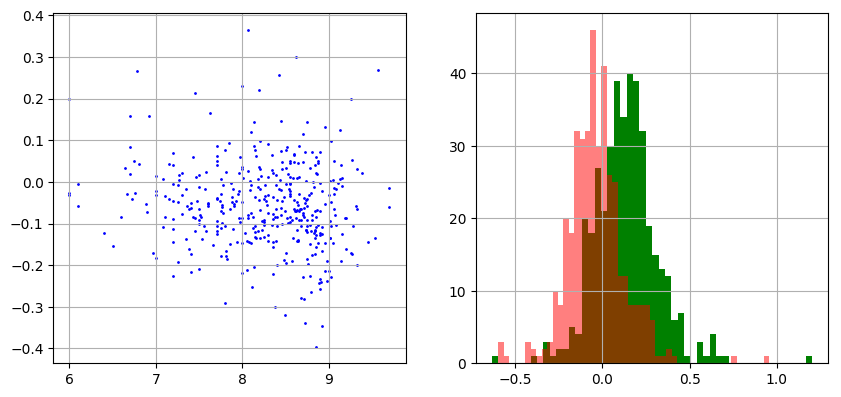

In [15]:
fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.scatter(ocage[:log_age],ocage[:kappalight20] , s=1, facecolor="blue")

ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.hist(ocage[:kappa10] , 50, density=false, facecolor="g")
PyPlot.hist(ocage[:kappalight10] , 50, density=false, facecolor="r", alpha=0.5)

PyPlot.show()